<a href="https://colab.research.google.com/github/Efefefef/IANNwTF-UniOsnabrueck/blob/main/Homework03_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
# Visualization function
def visualization(train_losses , train_accuracies , test_losses , test_accuracies):
    plt.figure()
    line1 , = plt.plot(train_losses , "b-")
    line2 , = plt.plot(test_losses , "r-") 
    line3 , = plt.plot(train_accuracies , "b:")
    line4 , = plt.plot(test_accuracies , "r:") 
    plt.xlabel("Epochs")
    plt.ylabel("Loss/Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

In [ ]:
# Prepare the data
def prepare_mnist_data(mnist_data, batch_size):
    mnist_data = mnist_data.map(lambda image, target: (tf.cast(image, tf.float32) / 128. - 1, target))
    mnist_data = mnist_data.map(lambda image, target: (tf.reshape(image, (-1,)), target))
    mnist_data = mnist_data.map(lambda image, target: (image, tf.one_hot(target, 10)))
    mnist_data.cache()
    mnist_data = mnist_data.shuffle(1000)
    mnist_data = mnist_data.batch(batch_size)
    mnist_data = mnist_data.prefetch(tf.data.AUTOTUNE)
    return mnist_data

In [ ]:
class MyModel(tf.keras.Model):
    # Define the layers of the model
    def __init__(self, n_unit):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    # Forward pass
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [ ]:
# Define the training step
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        predictions = model(input)
        loss = loss_function(target, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, predictions

# Define the test step
def test_step(model, image, target, loss_function):
    predictions = model(image)
    loss = loss_function(target, predictions)
    return loss, predictions

In [ ]:
# Test the model
def test(model, test_ds, loss_function):
    losses = []
    accuracy_aggregator = []
    for image, target in test_ds:
        loss, predictions = test_step(model, image, target, loss_function)
        losses.append(loss)
        accuracy_aggregator.append(np.mean(np.argmax(predictions, axis=1) == np.argmax(target, axis=1)))
    return tf.reduce_mean(losses), tf.reduce_mean(accuracy_aggregator)

In [ ]:
# Define the complete training function
def train(model, train_ds, test_ds, epochs, loss_function, optimizer, train_losses, train_accuracies, test_losses, test_accuracies):

    # Estimate the loss and accuracy on the train set before training
    loss, accuracy = test(model, train_ds, loss_function)
    train_losses.append(loss)       
    train_accuracies.append(accuracy)

    # Estimate the loss and accuracy on the test set before training
    loss, accuracy = test(model, test_ds, loss_function)
    test_losses.append(loss)      
    test_accuracies.append(accuracy)

    print("Pretraining, Loss: {}, Accuracy: {}, (Train)".format(train_losses[-1], train_accuracies[-1])) 
    print("Pretraining, Loss: {}, Accuracy: {}, (Test)".format(test_losses[-1], test_accuracies[-1])) 
    
    # Train the model
    for epoch in range(epochs):
        train_accuracy_aggregator = []
        losses = []
        for image, target in train_ds:
            loss, predictions = train_step(model, image, target, loss_function, optimizer)
            losses.append(loss)
            train_accuracy_aggregator.append(np.mean(np.argmax(predictions, axis=1) == np.argmax(target, axis=1)))

        # Estimate the loss and accuracy on the train set after training    
        train_losses.append(tf.reduce_mean(losses))
        train_accuracies.append(tf.reduce_mean(train_accuracy_aggregator))

        # Estimate the loss and accuracy on the test set after each epoch
        loss, accuracy = test(model, train_ds, loss_function)
        test_losses.append(loss)         
        test_accuracies.append(accuracy)

        print("Epoch: {}, Loss: {}, Accuracy: {}, (Train)".format(epoch + 1, train_losses[-1], train_accuracies[-1])) 
        print("Epoch: {}, Loss: {}, Accuracy: {}, (Test)".format(epoch + 1, test_losses[-1], test_accuracies[-1])) 

    return train_losses, train_accuracies, test_losses, test_accuracies

In [45]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 256

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

Pretraining, Loss: 3.428236961364746, Accuracy: 0.10238333333333334, (Train)
Pretraining, Loss: 3.435230255126953, Accuracy: 0.10123801916932908, (Test)
Epoch: 1, Loss: 0.3431757390499115, Accuracy: 0.8965, (Train)
Epoch: 1, Loss: 0.1648102104663849, Accuracy: 0.9488, (Test)
Epoch: 2, Loss: 0.15016420185565948, Accuracy: 0.9541166666666666, (Train)
Epoch: 2, Loss: 0.10366424173116684, Accuracy: 0.9692333333333333, (Test)
Epoch: 3, Loss: 0.1126386895775795, Accuracy: 0.9655166666666667, (Train)
Epoch: 3, Loss: 0.07869868725538254, Accuracy: 0.9755333333333334, (Test)
Epoch: 4, Loss: 0.09274271875619888, Accuracy: 0.9708666666666667, (Train)
Epoch: 4, Loss: 0.06337035447359085, Accuracy: 0.9809166666666667, (Test)
Epoch: 5, Loss: 0.07931424677371979, Accuracy: 0.97525, (Train)
Epoch: 5, Loss: 0.05517011135816574, Accuracy: 0.9828833333333333, (Test)
Epoch: 6, Loss: 0.06686540693044662, Accuracy: 0.9791833333333333, (Train)
Epoch: 6, Loss: 0.05925342068076134, Accuracy: 0.98135, (Test)
Ep

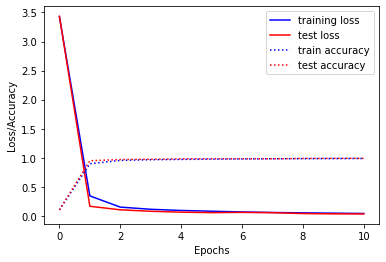

In [46]:
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

## ADJUSTING HYPERPARAMETERS

Observation is done by changing only one particular parameter, and having the remaining parameters the same as followings:

```
learning_rate = 0.1
n_unit = 256
batch_size = 32
```



### 1) Reducing layer size to from 256 to 32 neurons

Pretraining, Loss: 2.5646488666534424, Accuracy: 0.0983, (Train)
Pretraining, Loss: 2.56738543510437, Accuracy: 0.09554712460063898, (Test)
Epoch: 1, Loss: 0.6374214291572571, Accuracy: 0.7903333333333333, (Train)
Epoch: 1, Loss: 0.34630656242370605, Accuracy: 0.8962833333333333, (Test)
Epoch: 2, Loss: 0.361100971698761, Accuracy: 0.88845, (Train)
Epoch: 2, Loss: 0.29369503259658813, Accuracy: 0.9094, (Test)
Epoch: 3, Loss: 0.32193195819854736, Accuracy: 0.9009, (Train)
Epoch: 3, Loss: 0.2813875377178192, Accuracy: 0.9109, (Test)
Epoch: 4, Loss: 0.2975057065486908, Accuracy: 0.90975, (Train)
Epoch: 4, Loss: 0.2605935037136078, Accuracy: 0.9214833333333333, (Test)
Epoch: 5, Loss: 0.2799217998981476, Accuracy: 0.9146166666666666, (Train)
Epoch: 5, Loss: 0.26049619913101196, Accuracy: 0.9183333333333333, (Test)
Epoch: 6, Loss: 0.2641645073890686, Accuracy: 0.9195166666666666, (Train)
Epoch: 6, Loss: 0.24586394429206848, Accuracy: 0.92645, (Test)
Epoch: 7, Loss: 0.2535034120082855, Accurac

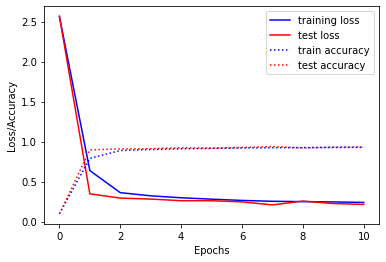

In [ ]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 32 # from 256 to 32 units

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**



### 2) Increasing batch size from 32 to 64

Pretraining, Loss: 2.608119487762451, Accuracy: 0.08851945628997868, (Train)
Pretraining, Loss: 2.6045608520507812, Accuracy: 0.08917197452229299, (Test)
Epoch: 1, Loss: 0.3538638949394226, Accuracy: 0.8897254797441365, (Train)
Epoch: 1, Loss: 0.15892276167869568, Accuracy: 0.9523420842217484, (Test)
Epoch: 2, Loss: 0.13896438479423523, Accuracy: 0.956956289978678, (Train)
Epoch: 2, Loss: 0.130630761384964, Accuracy: 0.9585887526652452, (Test)
Epoch: 3, Loss: 0.10091110318899155, Accuracy: 0.9685501066098081, (Train)
Epoch: 3, Loss: 0.10703783482313156, Accuracy: 0.9665345149253731, (Test)
Epoch: 4, Loss: 0.07976659387350082, Accuracy: 0.9748467484008528, (Train)
Epoch: 4, Loss: 0.08801666647195816, Accuracy: 0.972547974413646, (Test)
Epoch: 5, Loss: 0.06457675248384476, Accuracy: 0.9800606343283582, (Train)
Epoch: 5, Loss: 0.062467366456985474, Accuracy: 0.980577025586354, (Test)
Epoch: 6, Loss: 0.054077137261629105, Accuracy: 0.982476012793177, (Train)
Epoch: 6, Loss: 0.0418521910905

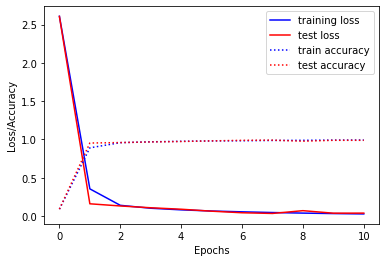

In [ ]:
num_epochs = 10
learning_rate = 0.1
batch_size = 64 # from 32 to 64 units
n_unit = 256 

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**



### 3) Increasing learning rate from 0.1 to 0.2

Pretraining, Loss: 2.620771646499634, Accuracy: 0.1021, (Train)
Pretraining, Loss: 2.6207985877990723, Accuracy: 0.1042332268370607, (Test)
Epoch: 1, Loss: 1.9617648124694824, Accuracy: 0.22988333333333333, (Train)
Epoch: 1, Loss: 1.7062016725540161, Accuracy: 0.23606666666666667, (Test)
Epoch: 2, Loss: 1.8333525657653809, Accuracy: 0.22946666666666668, (Train)
Epoch: 2, Loss: 1.5503777265548706, Accuracy: 0.3675, (Test)
Epoch: 3, Loss: 1.8131091594696045, Accuracy: 0.24701666666666666, (Train)
Epoch: 3, Loss: 1.8445121049880981, Accuracy: 0.18906666666666666, (Test)
Epoch: 4, Loss: 1.883575439453125, Accuracy: 0.20293333333333333, (Train)
Epoch: 4, Loss: 1.8907986879348755, Accuracy: 0.19756666666666667, (Test)
Epoch: 5, Loss: 1.7828809022903442, Accuracy: 0.24146666666666666, (Train)
Epoch: 5, Loss: 1.6452810764312744, Accuracy: 0.2684166666666667, (Test)
Epoch: 6, Loss: 1.6676523685455322, Accuracy: 0.28505, (Train)
Epoch: 6, Loss: 1.681351661682129, Accuracy: 0.2946, (Test)
Epoch: 

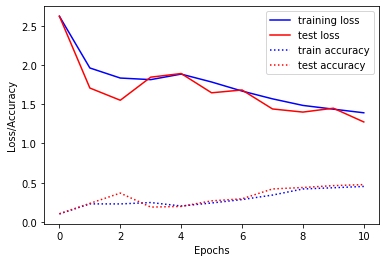

In [ ]:
num_epochs = 10
learning_rate = 0.2  # from 0.1 to 0.2
batch_size = 32
n_unit = 256

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)

visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**

Higher learning rate causing fluctuation in the performance. Learning rate is the step size while finding the minimum loss in gradient descent. Higher learning rate means the model might skip the optimal value for the minimum loss, thus makes the model has a slower performance in reaching the convergence.

### 4) Reducing 2 layers to 1 hidden layer (256 neurons)

In [ ]:
# Updating model to only 1 hidden layer

class MyModel(tf.keras.Model):
    # Define the layers of the model
    def __init__(self, n_unit):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        # self.dense2 = tf.keras.layers.Dense(n_unit, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    # Forward pass
    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        # x = self.dense2(x)
        x = self.out(x)
        return x

Pretraining, Loss: 3.1000752449035645, Accuracy: 0.07768333333333333, (Train)
Pretraining, Loss: 3.088195323944092, Accuracy: 0.07607827476038338, (Test)
Epoch: 1, Loss: 0.35209330916404724, Accuracy: 0.8957333333333334, (Train)
Epoch: 1, Loss: 0.14790496230125427, Accuracy: 0.95515, (Test)
Epoch: 2, Loss: 0.14843273162841797, Accuracy: 0.9548833333333333, (Train)
Epoch: 2, Loss: 0.11176656931638718, Accuracy: 0.9662166666666666, (Test)
Epoch: 3, Loss: 0.11362758278846741, Accuracy: 0.9652166666666666, (Train)
Epoch: 3, Loss: 0.07530330866575241, Accuracy: 0.9776333333333334, (Test)
Epoch: 4, Loss: 0.09285830706357956, Accuracy: 0.9711666666666666, (Train)
Epoch: 4, Loss: 0.06727126240730286, Accuracy: 0.9793333333333333, (Test)
Epoch: 5, Loss: 0.07956559956073761, Accuracy: 0.9752, (Train)
Epoch: 5, Loss: 0.06755644083023071, Accuracy: 0.9783333333333334, (Test)
Epoch: 6, Loss: 0.07002735882997513, Accuracy: 0.9772166666666666, (Train)
Epoch: 6, Loss: 0.07047361880540848, Accuracy: 0.

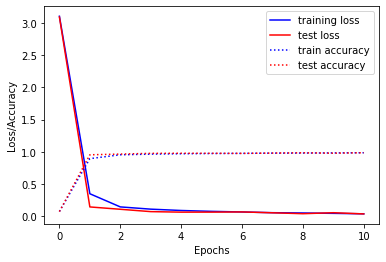

In [ ]:
num_epochs = 10
learning_rate = 0.1
batch_size = 32
n_unit = 256 

model = MyModel(n_unit)
(train_ds, test_ds), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

train_losses , train_accuracies , test_losses , test_accuracies = [], [], [], []

train_losses, train_accuracies, test_losses ,test_accuracies = train(
    model = model, 
    train_ds= prepare_mnist_data(train_ds, batch_size), 
    test_ds= prepare_mnist_data(test_ds, batch_size), 
    epochs= num_epochs, 
    loss_function= tf.keras.losses.CategoricalCrossentropy(), 
    optimizer = tf.keras.optimizers.SGD(learning_rate),
    train_losses=train_losses,
    train_accuracies=train_accuracies,
    test_losses=test_losses,
    test_accuracies=test_accuracies
)
visualization(train_losses, train_accuracies, test_losses, test_accuracies)

**Observation:**

